In [45]:
import numpy as np
import keras
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras.layers import Input, Dense, Activation
from keras.layers import Conv1D, AveragePooling1D, Conv2DTranspose
from keras.layers import Flatten, Reshape, Lambda
from keras.layers import Dropout
from keras.utils import plot_model
from keras import Model

import os
import os.path as osp
import sys
sys.path.append('/home/jcollins')

import ot
import numpy as np

import gc
from sklearn.preprocessing import StandardScaler

In [35]:
masses = [200,300,400,500]
signal_data_files = [np.load('/data1/users/jcollins/monosquark_samples/VV/VV+_'+str(mass)+'_12.npz') for mass in masses]

ttbarfiles = ['tt_12_0_' + str(i) + '.npz' for i in range(5)]
ttbarfiles.extend(['tt_12_1_' + str(i) + '.npz' for i in range(10)])
bg_data_files = [np.load('/data1/users/jcollins/monosquark_samples/ttbar/' + filename) for filename in ttbarfiles]

In [ ]:
masses = [200,300,400,500]
signal_data_files = [np.load('/data1/users/jcollins/monosquark_samples/VV/VV+_'+str(mass)+'_12.npz') for mass in masses]

ttbarfiles = ['tt_12_0_' + str(i) + '.npz' for i in range(5)]
ttbarfiles.extend(['tt_12_1_' + str(i) + '.npz' for i in range(10)])
bg_data_files = [np.load('/data1/users/jcollins/monosquark_samples/ttbar/' + filename) for filename in ttbarfiles]

In [59]:
data[5]

array([[0.26750331, 0.42749497, 0.96957147, ..., 0.        , 0.        ,
        0.        ],
       [0.13309115, 0.66734457, 1.02331924, ..., 0.        , 0.        ,
        0.        ],
       [0.08908538, 0.66637558, 1.01360214, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [36]:
signal_data = [file['constituents'] for file in signal_data_files]
signal_data = np.concatenate(signal_data, axis=0)
bg_data = [file['constituents'] for file in bg_data_files]
bg_data = np.concatenate(bg_data, axis=0)

np.random.shuffle(signal_data)
np.random.shuffle(bg_data)

In [37]:
print(len(bg_data),len(signal_data))

94614 247098


In [76]:
import gc as gc
gc.collect()
np.tensordot(event[:,0],event[])

TypeError: tensordot() missing 2 required positional arguments: 'a' and 'b'

In [78]:
np.sum(event[:,0]*event[:,1])

-1.3858095173166136

In [82]:
numtrain = 84000
numvalid = 10000
numtotal = numtrain+numvalid

labels = np.append(np.zeros(numtotal),np.ones(numtotal))
data = np.append(bg_data,signal_data,axis=0)
data[:,:]
perms = np.random.permutation(2*numtotal)
data = data[perms]
pts = np.zeros((len(data),1))
for i, event in enumerate(data):
    pts[i,0] = np.sum(event[:,0],axis=-1)
    jet_eta = np.sum(event[:,0]*event[:,1])/pts[i,0]
    jet_phi = np.sum(event[:,0]*event[:,2])/pts[i,0]
    event[:,1] = event[:,1] - jet_eta
    event[:,2] = event[:,2] - jet_phi
    event[:,0] = event[:,0] / pts[i,0]
labels = labels[perms]

scaler = StandardScaler()
scaler.fit(pts)
pts = scaler.transform(pts)

train_data = data[:numtrain*2]
valid_data = data[numtrain*2:]
train_labels = labels[:numtrain*2]
valid_labels = labels[numtrain*2:]
train_pts = pts[:numtrain*2]
valid_pts = pts[numtrain*2:]

In [88]:
train_data[10,:10]

array([[ 0.12098323, -0.14561312, -0.1552739 ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.1133058 , -0.18268865, -0.11722826,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.09925156, -0.13646062, -0.15103696,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.09304502, -0.17429303, -0.1058514 ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.05798759,  0.3694093 ,  0.24899878,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.05169403, -0.14765823, -0.1506059 ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.0374184 , -0.1749311 , -0.08685707,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.03215028,  0.20287216,  0.16448344,  0.        ,  0

In [89]:
dropprob = 0.1
nodes = 512

numparticles = len(bg_data[0])
lenparticle = len(bg_data[0,0])
inputs = Input(shape=(numparticles,lenparticle),name='input')
layer = Conv1D(nodes,1,activation='relu',name='1_conv1d_0')(inputs)
layer = Dropout(dropprob)(layer)
layer = Conv1D(nodes,1,activation='relu',name='2_conv1d_1')(layer)
layer = Dropout(dropprob)(layer)
layer = Conv1D(nodes,1,activation='relu',name='3_conv1d_2')(layer)
layer = AveragePooling1D(pool_size=numparticles,name='4_avgpool')(layer)
layer = Reshape((nodes,), name='5_reshape')(layer)

pt_input = Input(shape=(1,), name='pt_input')
layer = keras.layers.concatenate([layer, pt_input])

layer = Dense(nodes,activation='relu',name='6_dense_0')(layer)
layer = Dropout(dropprob)(layer)
layer = Dense(nodes,activation='relu',name='7_dense_1')(layer)
layer = Dropout(dropprob)(layer)
layer = Dense(nodes,activation='relu',name='8_dense_2')(layer)
layer = Dropout(dropprob)(layer)
output = Dense(1,activation='sigmoid',name='output')(layer)

model = Model(inputs=[inputs, pt_input], outputs=output)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())

In [90]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

save_period = 5
epochs = 200

output_dir = './models/'
experiment_name = 'second_jet_1'

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

model.fit([train_data,train_pts],train_labels,epochs=epochs,batch_size=100,validation_data=([valid_data,valid_pts],valid_labels),
         callbacks = callbacks)

Train on 168000 samples, validate on 20000 samples
Epoch 1/200
 48100/168000 [=======>......................] - ETA: 33s - loss: 0.5969

KeyboardInterrupt: 

In [15]:
from sklearn import metrics
scores = model.predict(valid_data)
fpr, tpr, thresholds = metrics.roc_curve(valid_labels, scores)

In [16]:
import matplotlib.pyplot as plt

In [27]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

/home/jcollins/EMD-VAE/env_END-VAE/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


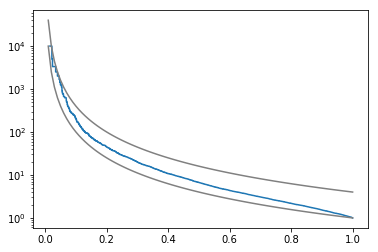

In [32]:
contourx = np.arange(0.01,1.01,0.01)
plt.plot(tpr,1/fpr)
plt.plot(contourx,4/np.square(contourx),color='gray')
plt.plot(contourx,1/np.square(contourx),color='gray')
plt.semilogy()
plt.show()

In [26]:
0.4/0.1**0.5

1.2649110640673518

In [10]:
model.fit(train_data,train_labels,epochs=200,batch_size=1600,validation_data=(valid_data,valid_labels))

Train on 400000 samples, validate on 20000 samples
Epoch 1/200
400000/400000 [==============================] - 97s 243us/step - loss: 0.6665 - val_loss: 0.6630
Epoch 2/200
400000/400000 [==============================] - 97s 242us/step - loss: 0.6642 - val_loss: 0.6600
Epoch 3/200
 16000/400000 [>.............................] - ETA: 1:32 - loss: 0.6582

KeyboardInterrupt: 

In [73]:
model.fit(train_data,train_labels,epochs=200,batch_size=300,validation_data=(valid_data,valid_labels))

Train on 400000 samples, validate on 20000 samples
Epoch 1/200
400000/400000 [==============================] - 106s 264us/step - loss: 0.6678 - val_loss: 0.6627
Epoch 2/200
400000/400000 [==============================] - 105s 263us/step - loss: 0.6616 - val_loss: 0.6589
Epoch 3/200
400000/400000 [==============================] - 105s 263us/step - loss: 0.6585 - val_loss: 0.6552
Epoch 4/200
400000/400000 [==============================] - 105s 263us/step - loss: 0.6539 - val_loss: 0.6517
Epoch 5/200
400000/400000 [==============================] - 105s 263us/step - loss: 0.6505 - val_loss: 0.6474
Epoch 6/200
 91800/400000 [=====>........................] - ETA: 1:19 - loss: 0.6492

KeyboardInterrupt: 

In [71]:
model.fit(train_data,train_labels,epochs=200,batch_size=300,validation_data=(valid_data,valid_labels))

Train on 400000 samples, validate on 20000 samples
Epoch 1/200
400000/400000 [==============================] - 48s 121us/step - loss: 0.6684 - val_loss: 0.6670
Epoch 2/200
400000/400000 [==============================] - 44s 111us/step - loss: 0.6628 - val_loss: 0.6586
Epoch 3/200
400000/400000 [==============================] - 44s 111us/step - loss: 0.6596 - val_loss: 0.6579
Epoch 4/200
400000/400000 [==============================] - 45s 111us/step - loss: 0.6577 - val_loss: 0.6575
Epoch 5/200
400000/400000 [==============================] - 45s 112us/step - loss: 0.6542 - val_loss: 0.6532
Epoch 6/200
400000/400000 [==============================] - 45s 112us/step - loss: 0.6518 - val_loss: 0.6489
Epoch 7/200
400000/400000 [==============================] - 45s 112us/step - loss: 0.6486 - val_loss: 0.6489
Epoch 8/200
400000/400000 [==============================] - 45s 112us/step - loss: 0.6473 - val_loss: 0.6468
Epoch 9/200
400000/400000 [==============================] - 45s 112u

KeyboardInterrupt: 

In [69]:
model.fit(train_data,train_labels,epochs=200,batch_size=300,validation_data=(valid_data,valid_labels))

Train on 400000 samples, validate on 20000 samples
Epoch 1/200
400000/400000 [==============================] - 21s 51us/step - loss: 0.6673 - val_loss: 0.6618
Epoch 2/200
400000/400000 [==============================] - 20s 49us/step - loss: 0.6566 - val_loss: 0.6518
Epoch 3/200
400000/400000 [==============================] - 20s 49us/step - loss: 0.6498 - val_loss: 0.6496
Epoch 4/200
400000/400000 [==============================] - 20s 49us/step - loss: 0.6469 - val_loss: 0.6510
Epoch 5/200
400000/400000 [==============================] - 20s 49us/step - loss: 0.6452 - val_loss: 0.6456
Epoch 6/200
400000/400000 [==============================] - 20s 49us/step - loss: 0.6442 - val_loss: 0.6471
Epoch 7/200
400000/400000 [==============================] - 20s 50us/step - loss: 0.6429 - val_loss: 0.6453
Epoch 8/200
400000/400000 [==============================] - 20s 50us/step - loss: 0.6423 - val_loss: 0.6453
Epoch 9/200
400000/400000 [==============================] - 20s 50us/step - 

KeyboardInterrupt: 

In [65]:
model.fit(train_data,train_labels,epochs=200,batch_size=300,validation_data=(valid_data,valid_labels))

Train on 400000 samples, validate on 20000 samples
Epoch 1/200
400000/400000 [==============================] - 13s 33us/step - loss: 0.6690 - val_loss: 0.6653
Epoch 2/200
400000/400000 [==============================] - 12s 31us/step - loss: 0.6620 - val_loss: 0.6617
Epoch 3/200
400000/400000 [==============================] - 12s 31us/step - loss: 0.6580 - val_loss: 0.6572
Epoch 4/200
400000/400000 [==============================] - 12s 31us/step - loss: 0.6546 - val_loss: 0.6593
Epoch 5/200
400000/400000 [==============================] - 12s 31us/step - loss: 0.6518 - val_loss: 0.6534
Epoch 6/200
400000/400000 [==============================] - 12s 31us/step - loss: 0.6494 - val_loss: 0.6520
Epoch 7/200
400000/400000 [==============================] - 12s 31us/step - loss: 0.6484 - val_loss: 0.6530
Epoch 8/200
400000/400000 [==============================] - 12s 31us/step - loss: 0.6473 - val_loss: 0.6489
Epoch 9/200
400000/400000 [==============================] - 12s 31us/step - 

KeyboardInterrupt: 

In [34]:
train_data[5]

array([[3.43942078e+02, 5.07611036e-01, 1.02473176e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.42019119e+02, 7.79691279e-01, 7.21251488e-01, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.07226105e+01, 1.52828991e-01, 1.67351723e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [39]:
np.sum(data[0,:,0],axis=-1)

703.7472639679909

In [43]:
data[0]

array([[ 0.22070922,  0.40778416, -2.45515513, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14192642, -0.61937547, -2.71475029, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1364755 ,  0.40481746, -2.4508605 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])